In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler,Subset,Dataset,random_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import ImageFile,Image
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!curl -L -o data.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/9adb4195-2a08-4a72-800b-0ceccdd92c56.jpg  
  inflating: images/9ae5ebcc-b744-458c-8ebc-c0bb00ded94a.jpg  
  inflating: images/9ae7c34f-e754-430a-af69-a269c82e0185.jpg  
  inflating: images/9aefd856-6027-4524-bf6b-585aaffc4f64.jpg  
  inflating: images/9af13c53-91e7-4dda-b880-f3d3fa0c3cc2.jpg  
  inflating: images/9afb1f5b-b579-4ea3-b6a8-11afe99c2ac0.jpg  
  inflating: images/9aff54d3-8d05-40e2-9961-0e497fdee70d.jpg  
  inflating: images/9b001318-5721-489f-956d-127dc01c4aba.jpg  
  inflating: images/9b116749-3595-40d6-b592-e78a8d534295.jpg  
  inflating: images/9b12ef52-33f7-431d-83a2-2b7ee3d55e76.jpg  
  inflating: images/9b157027-bb83-40c1-b61b-8bcce87a8c9b.jpg  
  inflating: images/9b1b93f3-4486-4f81-bc9c-22dc7e618e6f.jpg  
  inflating: images/9b1e81ed-04f0-4180-8ef3-051c94f64739.jpg  
  inflating: images/9b1f0e9e-db1c-48dd-835f-c61b1951a4b2.jpg  
  inflating: images/9b23284e-1261-44aa-abf9-3ed335c7ddb0.jpg  
  in

In [ ]:
!unzip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip

unzip:  cannot find or open https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip, https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip.zip or https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip.ZIP.


In [ ]:
train_data = pd.read_csv('/content/train.csv')
train_data.head()

,image_path,font,font_size,color
0,images/d101fd9a-83cf-4a6c-974f-16b505b0c637.jpg,Sarabun-Regular,22,#DF3030
1,images/7531c3c5-e990-4daf-b44c-6b6a3f4eb5fd.jpg,Prompt-Regular,18,#DF3030
2,images/a5f69a02-3a51-457a-b043-6284ea1fd48e.jpg,FkBeautyRegular,28,#FF6666
3,images/52878fc8-1af5-497f-ac12-2834d8a5c27f.jpg,FkBeautyRegular,28,#0000FF
4,images/188ff66c-272f-4644-8c00-7e2cc171f1e7.jpg,KhaosuayThin,24,#DF3030


In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data.head()

,image_path,font,font_size,color
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,NaN,NaN,NaN
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,NaN,NaN,NaN
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,NaN,NaN,NaN
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,NaN,NaN,NaN
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,NaN,NaN,NaN


In [ ]:
def file_exists_in_folder(folder_path, target_file_name):
    for root, dirs, files in os.walk(folder_path):
        if target_file_name in files:
            return True
    return False

folder_path = '/content/images'
file_name = 'd101fd9a-83cf-4a6c-974f-16b505b0c637.jpg'
exists = file_exists_in_folder(folder_path, file_name)
print(f"train file found: {exists}")
file_name = '158b1476-5938-45dc-be90-9e50327c245d.jpg'
exists = file_exists_in_folder(folder_path, file_name)
print(f"test file found: {exists}")

train file found: True
test file found: True


In [ ]:
line_storage = []

for root, dirs, files in os.walk(folder_path):
    group = []
    count = 0

    # Collect lines for this group
    for i in range(min(5, len(files))):
        line = f'{root} , {dirs} , {files[i]}'
        group.append(line)

    # Check if this group is already stored
    if group not in line_storage:
        line_storage.append(group)

# Print grouped lines
for group in line_storage:
    for line in group:
        print(line)
    print()  # Enter a new line after each group


/content/images , [] , 7aaeb8e3-7136-4c53-a321-6a652f0fc015.jpg
/content/images , [] , 0d986c51-769a-470c-92b2-767a90d51465.jpg
/content/images , [] , 0450c171-f3fc-4079-a55a-271804c0522a.jpg
/content/images , [] , 703db4b7-cae8-4f58-af56-b6f6a0c5a76a.jpg
/content/images , [] , 3ee42f44-0bfe-4751-a4b2-bb8bd86c2c65.jpg



In [ ]:
train_data['image_path'].head().to_string(index=False)

'images/d101fd9a-83cf-4a6c-974f-16b505b0c637.jpg\nimages/7531c3c5-e990-4daf-b44c-6b6a3f4eb5fd.jpg\nimages/a5f69a02-3a51-457a-b043-6284ea1fd48e.jpg\nimages/52878fc8-1af5-497f-ac12-2834d8a5c27f.jpg\nimages/188ff66c-272f-4644-8c00-7e2cc171f1e7.jpg'

In [ ]:
train_data['image_path'][1]

'images/7531c3c5-e990-4daf-b44c-6b6a3f4eb5fd.jpg'

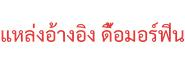

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import io
from PIL import Image
i=cv2.imread('/content/images/d101fd9a-83cf-4a6c-974f-16b505b0c637.jpg')
cv2_imshow(i)

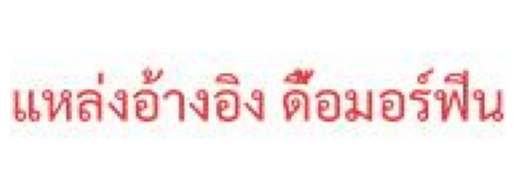

In [ ]:
from skimage import io
img_drive = io.imread('/content/images/d101fd9a-83cf-4a6c-974f-16b505b0c637.jpg')
plt.imshow(img_drive)
plt.axis('off')  # Hide the axis
plt.show()

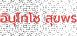

In [ ]:
i=cv2.imread('/content/images/7531c3c5-e990-4daf-b44c-6b6a3f4eb5fd.jpg')
cv2_imshow(i)

In [ ]:
i.shape

(36, 77, 3)

In [ ]:
img_drive.shape

(60, 185, 3)

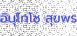

In [ ]:
image_RGB = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
cv2_imshow(image_RGB)

In [ ]:
import cv2

def get_color_code_cv2(image, x, y):
    # Access the pixel value at (x, y)
    b, g, r = image[y, x]
    # Convert BGR to RGB
    rgb = (r, g, b)
    return rgb

# Example usage
color_code = get_color_code_cv2(i, 10, 20)
print(f'RGB Color Code: {color_code}')


RGB Color Code: (255, 210, 200)


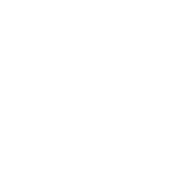

In [ ]:
def display_color_code(color_code):
    plt.figure(figsize=(2, 2))
    plt.imshow([[color_code]])
    plt.axis('off')  # Hide axis
    plt.show()

color_code = (255, 255, 255)  # white
display_color_code(color_code)

In [ ]:
#!pip install Pillow
def display_color_code_tkinter(color_code):
    if color_code.startswith('#'):
        color_code = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
    img = Image.new('RGB', (1, 1), color_code)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(color_code)

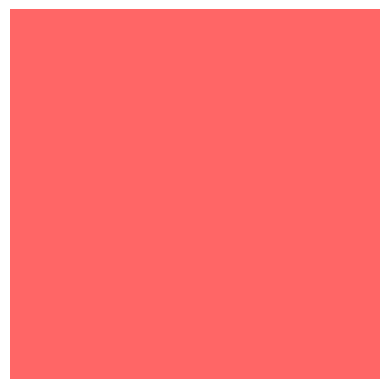

(255, 102, 102)


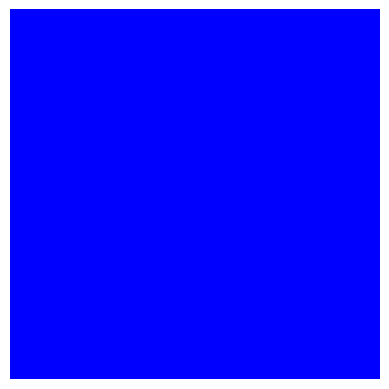

(0, 0, 255)


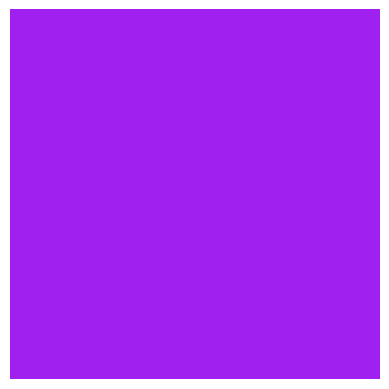

(160, 32, 240)


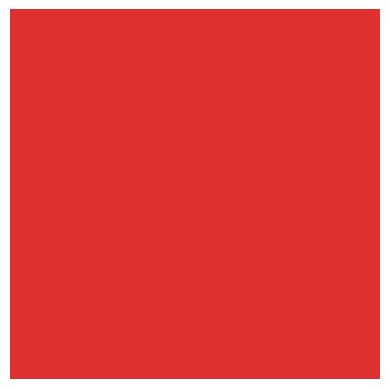

(223, 48, 48)


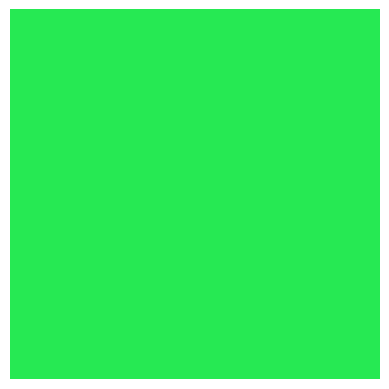

(38, 233, 83)


In [ ]:
a = ['#FF6666', '#0000FF','#A020F0','#DF3030','#26E953']
for b in a:
    display_color_code_tkinter(b)

In [ ]:
type(i)

numpy.ndarray

In [ ]:
blue_channel, green_channel, red_channel = cv2.split(i)

# Determine which channel contains the RGB information
# For example, suppose red channel contains the color
# and green and blue channels are grayscale
color_channel = red_channel
gray_channel_1 = green_channel
gray_channel_2 = blue_channel

# Find the unique RGB values (assuming grayscale channels have the same values)
unique_color_values = np.unique(color_channel)

# Display or process the RGB values
print("Unique RGB values:", unique_color_values)

Unique RGB values: [113 115 118 120 121 122 123 125 127 129 130 132 133 134 135 136 137 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255]


In [ ]:
def create_input(f):
    b = []
    for i in f:
        a = os.path.join('/content/', str(i))
        img = cv2.imread(a)
        img = cv2.resize(img, (32, 32))
        img = img.flatten()
        b.append(img)
    return np.array(b)

In [ ]:
#group data, make train_data[0] path by '/content/ +
class textdata(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.root_dirs=root_dir
        self.label=label
        self.image_paths=label['image_path']
        self.fonts=label['font']
        self.sizes=label['font_size']
        self.colors=label['color']
        self.transform=transform
        self.sample=[]
        a = create_input(self.image_paths)
        for root, image_path, font, size, color in zip(self.root_dirs, a, self.fonts, self.sizes, self.colors):

            self.sample.append((image_path, font, size, color))
            #print(self.sample,'\n/////\n')

    def __len__(self):
        return len(self.sample)
    def __getitem__(self, idx):
        img,font,size,color=self.sample[idx]
        #img=Image.open(img).convert('RGB')
        if self.transform:
            img = Image.fromarray(img)
            img=self.transform(img)
        return img,font,size,color

In [ ]:
transform = transforms.Compose([
    #transforms.Resize((28, _)),
    transforms.ToTensor()
])
dataset = textdata('/content/images', train_data, transform)
##seperate train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
#copy_files_to_new_folders(f'/content', train_files, val_files)
##map data
train_loader, val_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
def training(images,labels,model,loss_fn,optimizer, train_loss, correct):
    #images, labels = images.to(device), labels.to(device)  # Move data to GPU
    #images = images.view(images.size(0), -1)
    pred = model(images)
    loss = loss_fn(pred, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    correct += (pred.argmax(1) == labels).float().sum().item()
    return train_loss, correct

In [ ]:
def validation(images,labels,model,loss_fn,test_loss, correct):
    #images, labels = images.to(device), labels.to(device)  # Move data to GPU
    #images = images.view(images.size(0), -1)
    if images.shape[1] != model.fc1.in_features:
        raise ValueError(f"Input features ({images.shape[1]}) don't match fc1 layer ({model.fc1.in_features})")
    pred = model(images)
    test_loss += loss_fn(pred, labels).item()
    correct += (pred.argmax(1) == labels).float().sum().item()
    return test_loss, correct

In [ ]:
torch.manual_seed(42)
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_fonts = pd.concat([train_data['font'], test_data['font']]).unique()
all_sizes = pd.concat([train_data['font_size'], test_data['font_size']]).unique()
all_colors = pd.concat([train_data['color'], test_data['color']]).unique()

font_to_index = {font: idx for idx, font in enumerate(all_fonts)}
size_to_index = {size: idx for idx, size in enumerate(all_sizes)}
color_to_index = {color: idx for idx, color in enumerate(all_colors)}

# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, test_loader,i=0):
    training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        a=[]
        for batch in train_loader:
            if i==0:
                images, labels = batch[0], batch[1]
                label_to_index = font_to_index # Use font mapping
            elif i==1:
                images, labels = batch[0], batch[2]
                label_to_index = size_to_index # Use size mapping
            else:
                images, labels = batch[0], batch[3]
                label_to_index = color_to_index # Use color mapping

            # Flatten images if necessary (depends on your model)
            images = images.view(images.size(0), -1)
            labels = torch.tensor([label_to_index[label] for label in labels], dtype=torch.long)
            train_loss, correct = training(images, labels, model, loss_function, optimizer, train_loss, correct)

        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        test_loss, correct = 0, 0
        a=[]
        for batch in test_loader:
            if i==0:
                images, labels = batch[0], batch[1]
            elif i==1:
                images, labels = batch[0], batch[2]
            else:
                images, labels = batch[0], batch[3]

            images = images.view(images.size(0), -1)  # Flatten
            labels = torch.tensor([label_to_index[label] for label in labels], dtype=torch.long)
            test_loss, correct = validation(images, labels, model, loss_function, test_loss, correct)

        # save validation logs
        training_logs["validate_loss"].append(test_loss/ len(test_loader))
        training_logs["validate_acc"].append(correct / len(test_loader.dataset))

        if epoch % 5 == 0:
          print(f"Epochs {epoch}".ljust(10),
                f"train loss {training_logs['train_loss'][-1]:.5f}",
                f"train acc {training_logs['train_acc'][-1]:.5f}",

                f"validate loss {training_logs['validate_loss'][-1]:.5f}",
                f"validate acc {training_logs['validate_acc'][-1]:.5f}",
                )
          print("-"*80)
    plot_graph(training_logs)
    return model

In [ ]:
class DropoutNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
def evaluate(paths, model, device):
    model.to(device)
    model.eval()
    predictions = []
    for idx, path in enumerate(paths):
        img = transform(Image.open(path)).to(device)
        print("Image shape:", img.shape)
        img = img.view(-1, 3072)
        pred = model(img)
        pred = pred.argmax(1).item()
        predictions.append(pred)
    return predictions

--------------------------------------------------------------------------------


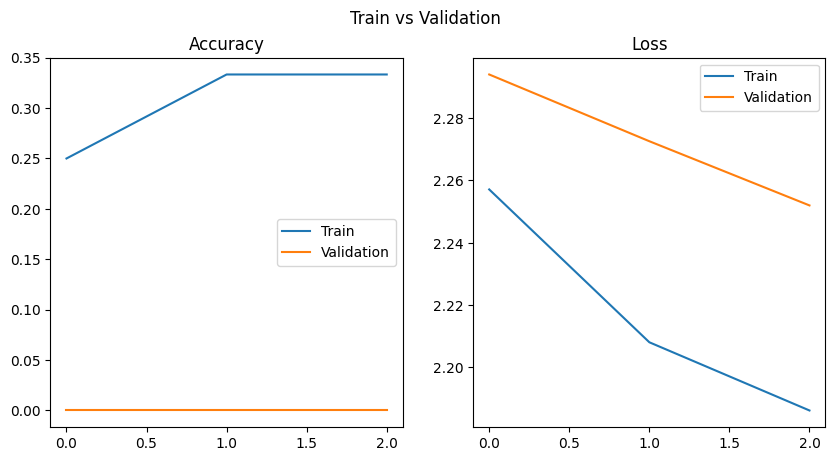

In [ ]:
n_epochs = 3
drop_model = DropoutNN3().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)
b = create_input(test_data['image_path'])
b = Image.fromarray(b)
b = transform(b)
dropout_model = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)
pred_font = dropout_model(b) #tensor
#dropout_model = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader,1)
#pred_size = dropout_model(b)
#dropout_model = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader,2)
#pred_color = dropout_model(b)
##pred_color = evaluate(b, dropout_model, device)

In [ ]:
#result = pd.DataFrame({'image_path': test_data['image_path'], 'font': pred_font, 'font_size': pred_size, 'color': pred_color})
#result
#result.to_csv('result.csv', index=False)

In [ ]:
train_data['font'].value_counts()

,count
font,
Sarabun-Regular,1440
Prompt-Regular,1440
FkBeautyRegular,1440
KhaosuayThin,1440
NotoSerifThai-Regular,1440
Kodchasan-Regular,1440
Athiti-Regular,1440


In [ ]:
train_data['font_size'].value_counts()

,count
font_size,
22,1680
18,1680
28,1680
24,1680
26,1680
20,1680


In [ ]:
train_data['color'].value_counts()

,count
color,
#DF3030,2016
#FF6666,2016
#0000FF,2016
#A020F0,2016
#26E953,2016


In [ ]:
from sklearn.ensemble import RandomForestClassifier
def create_input(f):
  b=[]
  for i in f:
    a=os.path.join('/content/',i)
    b.append(cv2.imread(a))
  return b
def create_test(f,C):
  x_test1=[]
  for i in range(10080):
    if i>=len(f):
      x_test1.append(b[i])
      continue
    a=C[i]
    x_test1.append(a)
  return x_test1
def model1(p,q=train_data['image_path'],r=test_data['image_path']): #q=train i_p , p=train output , r=test i_p
  b=create_input(q)
  c=create_input(r)
  x=pd.get_dummies(b).values
  y=pd.get_dummies(p).values
  x_test=create_test(c,b)
  x_test2=pd.get_dummies(x_test).values
  model = RandomForestClassifier()
  model.fit(x, y)
  y_pred = model.predict(x_test2)
  return y_pred

In [ ]:
#output=pd.DataFrame({
#    'image_path': test_data['image_path'],
#    'font': model1(train_data['font'])[:len(test_data['image_path'])],
#    'font_size': model1(train_data['font_size'])[:len(test_data['image_path'])],
#    'color': model1(train_data['color'])[:len(test_data['image_path'])]
#    })
#output

In [ ]:
b=[]
for i in train_data['image_path']:
  a=os.path.join('/content/',i)
  b.append(a)
b

['/content/images/d101fd9a-83cf-4a6c-974f-16b505b0c637.jpg',
 '/content/images/7531c3c5-e990-4daf-b44c-6b6a3f4eb5fd.jpg',
 '/content/images/a5f69a02-3a51-457a-b043-6284ea1fd48e.jpg',
 '/content/images/52878fc8-1af5-497f-ac12-2834d8a5c27f.jpg',
 '/content/images/188ff66c-272f-4644-8c00-7e2cc171f1e7.jpg',
 '/content/images/f0283bbb-9f1c-4eaf-a8c4-25788508f5f4.jpg',
 '/content/images/c3255196-16a4-4232-bb38-259304d3bf9c.jpg',
 '/content/images/60e7f736-8f6a-41a4-ae43-b07457a1fd71.jpg',
 '/content/images/06df32f1-37dc-4858-af68-7b33e1984906.jpg',
 '/content/images/a80f320a-9e5c-4e41-8b5c-3f5ff0296660.jpg',
 '/content/images/e8c5700d-7afe-4445-bfd0-6f35396f24db.jpg',
 '/content/images/298b2bac-cf6c-49f0-8130-a03561632526.jpg',
 '/content/images/154f790e-733e-43c5-b044-82c77d0d3d07.jpg',
 '/content/images/3ea1f543-37d4-49ec-a651-e0dc7406588f.jpg',
 '/content/images/09257cb7-a96c-45a2-81f5-460fcca96349.jpg',
 '/content/images/e4458a21-49d1-4fd9-99c4-a5ce579c1a73.jpg',
 '/content/images/ba5816

In [ ]:
def create_input(f):
  b=[]
  for i in f:
    a=os.path.join('/content/',i)
    b.append(a)
  return b
b=create_input(train_data['image_path'])
C=create_input(test_data['image_path'])

In [ ]:
#for fun
y=train_data[['font']].values
x=pd.get_dummies(b).values
x_test=pd.get_dummies(C).values
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
#y_pred = model.predict(x_test)

In [ ]:
x_test1=[]
for i in range(len(train_data)):
  if i>=len(x_test):
    x_test1.append(b[i])
    continue
  a=C[i]
  x_test1.append(a)
len(x_test1)
x_test2=pd.get_dummies(x_test1).values

In [ ]:
y_pred = model.predict(x_test2)

In [ ]:
y_pred

array(['KhaosuayThin', 'KhaosuayThin', 'Athiti-Regular', ...,
       'Sarabun-Regular', 'Kodchasan-Regular', 'Kodchasan-Regular'],
      dtype=object)

In [ ]:
len(x_test1)

10080

In [ ]:
len(test_data['image_path'])

2520

In [ ]:
output=pd.DataFrame({'image_path': test_data['image_path'],'font': y_pred[:len(test_data['image_path'])]})
output

,image_path,font
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,KhaosuayThin
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,KhaosuayThin
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,Athiti-Regular
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,Prompt-Regular
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,Kodchasan-Regular
...,...,...
2515,images/bb5c8429-0a43-4816-8b2f-6687b381e98f.jpg,Kodchasan-Regular
2516,images/2dde11bf-6aaa-45e3-a16a-65e0a3e35c6a.jpg,KhaosuayThin
2517,images/c8e2da57-f55f-47d0-b664-908d4006a39f.jpg,Kodchasan-Regular
2518,images/1bd9e291-3476-4560-b807-86f94ea3b8ad.jpg,Kodchasan-Regular


In [ ]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def create_input(f):
    b = []
    for i in f:
        a = os.path.join('/content/', i)
        img = cv2.imread(a)
        if img is not None:
            img = cv2.resize(img, (32, 32))
            img = img.flatten()
            b.append(img)
    return np.array(b)

def model1(p, q=train_data['image_path'], r=test_data['image_path']):  # q=train ip, p=train output, r=test ip
    x = create_input(q)
    x_test = create_input(r)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x_test = scaler.transform(x_test)
    y = p.values
    model = RandomForestClassifier()
    model.fit(x, y)
    y_pred = model.predict(x_test)
    return y_pred

output = pd.DataFrame({
    'image_path': test_data['image_path'],
    'font': model1(train_data['font'])[:len(test_data['image_path'])],
    'font_size': model1(train_data['font_size'])[:len(test_data['image_path'])],
    'color': model1(train_data['color'])[:len(test_data['image_path'])]
})
output
### END CODE HERE ###

,image_path,font,font_size,color
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,KhaosuayThin,28,#26E953
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,KhaosuayThin,24,#0000FF
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,FkBeautyRegular,20,#FF6666
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,FkBeautyRegular,18,#FF6666
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,KhaosuayThin,26,#DF3030
...,...,...,...,...
2515,images/bb5c8429-0a43-4816-8b2f-6687b381e98f.jpg,NotoSerifThai-Regular,18,#A020F0
2516,images/2dde11bf-6aaa-45e3-a16a-65e0a3e35c6a.jpg,Sarabun-Regular,18,#A020F0
2517,images/c8e2da57-f55f-47d0-b664-908d4006a39f.jpg,FkBeautyRegular,28,#26E953
2518,images/1bd9e291-3476-4560-b807-86f94ea3b8ad.jpg,FkBeautyRegular,28,#0000FF


In [ ]:
output.to_csv('output_workshop_finalver.csv', index=False)